# Cooley-Tukey FFT Kullanarak Görüntü Gürültüsünü Giderme

**Abdullah Berkay Uymaz**  
**191180083**


## Giriş
Bu rapor, Cooley-Tukey Hızlı Fourier Dönüşümü'nü (FFT) kullanarak etkili bir görüntü gürültü giderme algoritması geliştirmeyi amaçlamaktadır. Görüntü işleme, dijital görüntülerin analiz edilmesi ve işlenmesi sürecidir. Gürültü, görüntülerin kalitesini düşüren ve istenmeyen rastgele sinyaller veya bilgidir. Bu çalışmada, özellikle Gauss ve tuz-biber gibi yaygın gürültü türleri üzerinde durulacaktır.

### Fourier Dönüşümü Nedir?
Fourier Dönüşümü, bir sinyalin zaman veya uzay alanındaki temsilini, frekans alanındaki temsiline dönüştüren matematiksel bir işlemdir. Görüntülerde bu dönüşüm, görüntüdeki frekans bileşenlerini ayrıştırarak gürültüyü analiz etmemizi ve filtrelememizi sağlar. Hızlı Fourier Dönüşümü (FFT), Fourier Dönüşümü'nün hızlı bir hesaplama yöntemidir.

Fourier dönüşümü, $ f(x) $ fonksiyonunun Fourier dönüşümünü $ F(u) $ ile ifade eder:

$$
F(u) = \int_{-\infty}^{\infty} f(x) e^{-i 2 \pi ux} \, dx
$$

Ayrık Fourier dönüşümü (DFT) ise aşağıdaki formülle hesaplanır:

$$
X_k = \sum_{n=0}^{N-1} x_n e^{-i \frac{2\pi}{N} kn}
$$

FFT'nin avantajı, DFT'nin hesaplama karmaşıklığını $ O(N^2) $'den $ O(N \log N) $'ye düşürmesidir. FFT'nin temel fikri, DFT'yi daha küçük parçalara ayırmak ve bu parçaların sonuçlarını birleştirmektir.

### Cooley-Tukey FFT Algoritması
Cooley-Tukey FFT algoritması, Fourier Dönüşümü'nü hızlı bir şekilde hesaplamak için kullanılan en yaygın yöntemdir. Bu algoritma, ayrık Fourier dönüşümünü (DFT) $ O(N \log N) $ zaman karmaşıklığıyla hesaplayarak, doğrudan hesaplama yöntemine kıyasla büyük bir hız avantajı sağlar. Algoritma, veri setini yinelenen olarak ikiye bölerek çalışır ve bu bölme işlemini bitene kadar devam ettirir.

Cooley-Tukey algoritması, $N$ uzunluğundaki bir diziyi iki $N/2$ uzunluğundaki diziye ayırarak çalışır. Bu, şu şekilde ifade edilir:

$$
X[k] = \sum_{n=0}^{N-1} x[n] e^{-i 2 \pi k n / N} = \sum_{n=0}^{N/2-1} x[2n] e^{-i 2 \pi k (2n) / N} + \sum_{n=0}^{N/2-1} x[2n+1] e^{-i 2 \pi k (2n+1) / N}
$$

Bu, dizinin tek ve çift indeksli örneklerini ayrı ayrı işleyerek hesaplamayı optimize eder.

## 1. Veri Toplama ve Ön İşleme
### Veri Toplama
Gürültülü görüntülerin oluşturulması için çeşitli yöntemler kullanılabilir. Bu raporda, Gauss ve tuz-biber gürültüleri ekleyerek gürültülü görüntüler oluşturacağız.

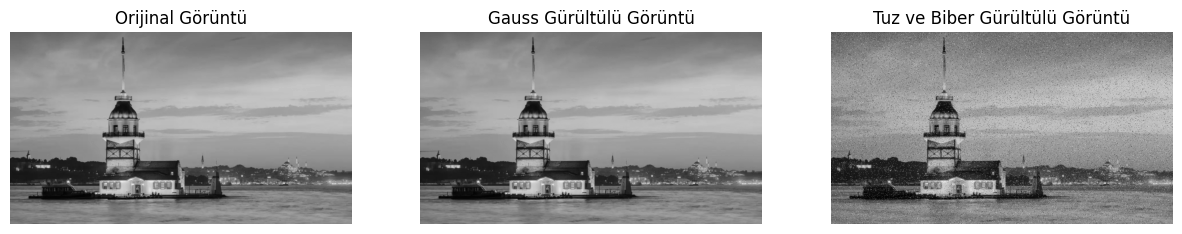

In [32]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Örnek görüntüyü yükleyin
image = cv2.imread('test.jpg', 0)  # Gri tonlamalı görüntü

# Gauss gürültüsü ekleme
mean = 0
var = 0.1
sigma = var ** 0.5
gaussian_noise = np.random.normal(mean, sigma, image.shape)
noisy_image_gauss = image + gaussian_noise

# Salt-and-pepper gürültüsü ekleme için düzeltmeler
amount = 0.05  # Gürültünün miktarı
s_vs_p = 0.5  # Tuz ve biber oranı
noisy_image_sp = np.copy(image)  # Gürültülü görüntü için kopya oluştur

# Tuz için koordinatları hesapla ve uygula
num_salt = np.ceil(amount * image.size * s_vs_p).astype(int)
x_coords = np.random.randint(0, image.shape[0], num_salt)
y_coords = np.random.randint(0, image.shape[1], num_salt)
noisy_image_sp[x_coords, y_coords] = 255

# Biber için koordinatları hesapla ve uygula
num_pepper = np.ceil(amount * image.size * (1. - s_vs_p)).astype(int)
x_coords = np.random.randint(0, image.shape[0], num_pepper)
y_coords = np.random.randint(0, image.shape[1], num_pepper)
noisy_image_sp[x_coords, y_coords] = 0

# Gürültülü görüntüleri görselleştirme
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Orijinal Görüntü')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(noisy_image_gauss, cmap='gray')
plt.title('Gauss Gürültülü Görüntü')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(noisy_image_sp, cmap='gray')
plt.title('Tuz ve Biber Gürültülü Görüntü')
plt.axis('off')
plt.show()

### Ön İşleme
Gürültülü görüntüleri gerektiği gibi önceden işlemek önemlidir. Bu, yeniden boyutlandırmayı, normalleştirmeyi veya renk uzaylarını dönüştürmeyi içerebilir. Normalizasyon, görüntü piksellerini belirli bir aralıkta (genellikle [0,1] veya [0,255]) tutmak için kullanılan yaygın bir tekniktir.

In [33]:
# Normalizasyon
def normalize_image(image):
    normalized_image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return normalized_image

# Normalizasyon işlemi
normalized_image_gauss = normalize_image(noisy_image_gauss)
normalized_image_sp = normalize_image(noisy_image_sp)

## 2. Cooley-Tukey FFT'nin Uygulanması
### FFT Teorisi
FFT, bir sinyalin frekans bileşenlerini analiz etmek için kullanılan ayrık Fourier dönüşümünün (DFT) hızlı bir algoritmasıdır. DFT, bir sinyalin zaman veya uzay alanındaki örneklerini alarak frekans alanındaki bileşenlerine ayırır. Cooley-Tukey algoritması, DFT'nin hesaplamalarını optimize ederek işlem süresini büyük ölçüde azaltır.

### Cooley-Tukey FFT Algoritmasının Uygulanması
Görüntülerin Fourier Dönüşümünün etkili bir şekilde hesaplanması için Cooley-Tukey FFT algoritmasını kullanacağız. Bu aşamada hesaplamayı hızlandırmak için çoklu iş parçacığı veya SIMD (Tek Talimat, Çoklu Veri) talimatları gibi optimizasyonları göz önünde bulundurabiliriz.

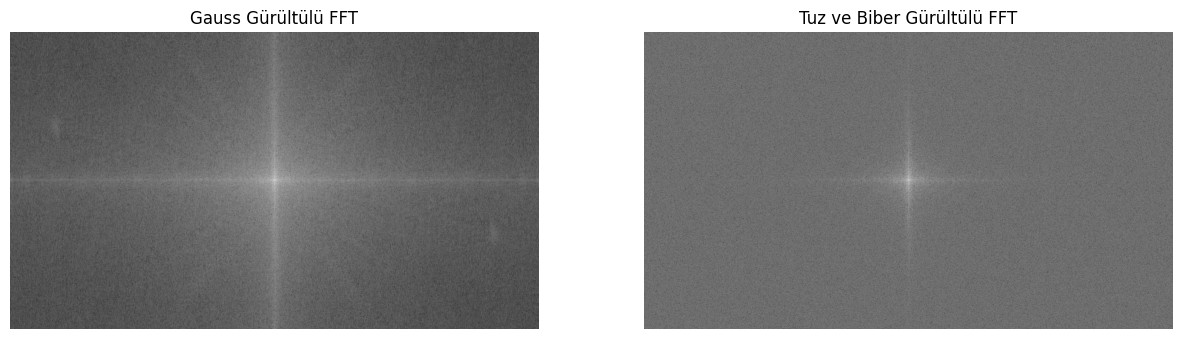

In [34]:
# FFT uygulaması
def apply_fft(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift))
    return fshift, magnitude_spectrum

# FFT'yi uygulama
fshift_gauss, magnitude_spectrum_gauss = apply_fft(normalized_image_gauss)
fshift_sp, magnitude_spectrum_sp = apply_fft(normalized_image_sp)

# Frekans spektrumunu görselleştirme
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(magnitude_spectrum_gauss, cmap='gray')
plt.title('Gauss Gürültülü FFT')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(magnitude_spectrum_sp, cmap='gray')
plt.title('Tuz ve Biber Gürültülü FFT')
plt.axis('off')
plt.show()

## 3. Frekans Alanı Gürültüsünü Giderme
### Frekans Alanı Filtreleme
Frekans alanında gürültü giderme tekniklerini uygulayarak, görüntüdeki istenmeyen yüksek frekanslı bileşenleri filtreleyebiliriz. Frekans alanı filtreleme, görüntü ayrıntılarını korurken gürültüyü bastırmak için kullanılan etkili bir yöntemdir.

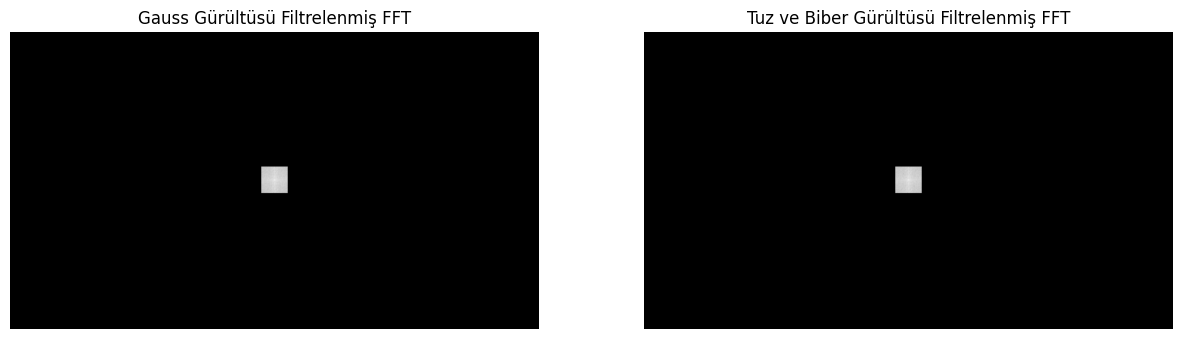

In [43]:
# Frekans alanında filtreleme (ideal düşük geçiş filtresi)
def ideal_low_pass_filter(fshift, cutoff):
    rows, cols = fshift.shape
    crow, ccol = rows // 2 , cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    mask[crow-cutoff:crow+cutoff, ccol-cutoff:ccol+cutoff] = 1
    fshift_filtered = fshift * mask
    return fshift_filtered

# Filtreyi uygulama
cutoff = 30  # Kesim frekansı
fshift_gauss_filtered = ideal_low_pass_filter(fshift_gauss, cutoff)
fshift_sp_filtered = ideal_low_pass_filter(fshift_sp, cutoff)

# Filtrelenmiş frekans spektrumunu görselleştirme
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
# Add a small constant, e.g., 1e-10, to avoid log(0)
plt.imshow(20*np.log(np.abs(fshift_gauss_filtered) + 1e-10), cmap='gray')
plt.title('Gauss Gürültüsü Filtrelenmiş FFT')
plt.axis('off')
plt.subplot(1, 2, 2)
# Similarly, add a small constant here as well
plt.imshow(20 * np.log(np.abs(fshift_sp_filtered) + 1e-10), cmap='gray')
plt.title('Tuz ve Biber Gürültüsü Filtrelenmiş FFT')
plt.axis('off')
plt.show()

### Wiener Filtreleme
Wiener filtreleme, frekans alanında gürültüyü bastırmak için kullanılan adaptif bir tekniktir. Bu filtre, hem sinyal hem de gürültünün istatistiksel özelliklerini göz önünde bulundurarak optimal bir filtreleme gerçekleştirir.

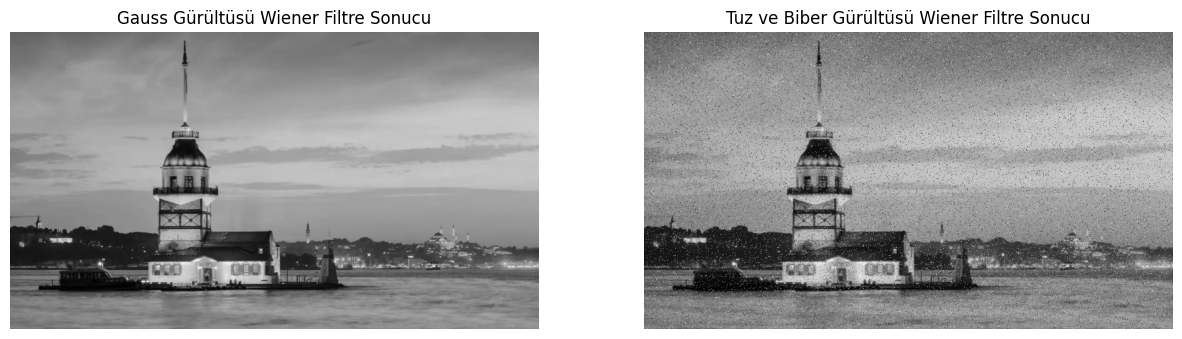

In [36]:
from scipy.signal import wiener

# Wiener filtreleme
wiener_gauss = wiener(normalized_image_gauss)
wiener_sp = wiener(normalized_image_sp)

# Wiener filtre sonuçlarını görselleştirme
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(wiener_gauss, cmap='gray')
plt.title('Gauss Gürültüsü Wiener Filtre Sonucu')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(wiener_sp, cmap='gray')
plt.title('Tuz ve Biber Gürültüsü Wiener Filtre Sonucu')
plt.axis('off')
plt.show()

## 4. Ters FFT ve Görüntü Yeniden Oluşturma
Frekans alanında gürültü giderildikten sonra, görüntüleri tekrar uzaysal alana dönüştürmek için ters bir FFT gerçekleştirilir.

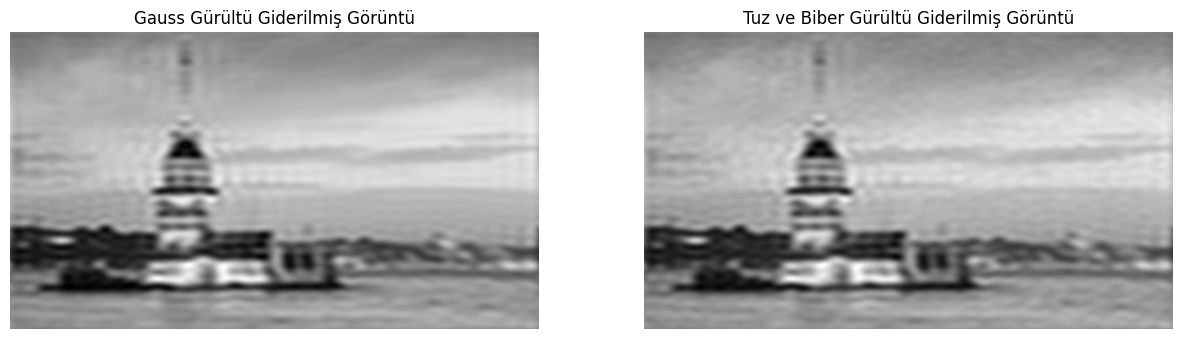

In [37]:
# Ters FFT uygulaması
def apply_ifft(fshift_filtered):
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

# Ters FFT'yi uygulama
img_gauss_back = apply_ifft(fshift_gauss_filtered)
img_sp_back = apply_ifft(fshift_sp_filtered)

# Sonuçları görselleştirme
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_gauss_back, cmap='gray')
plt.title('Gauss Gürültü Giderilmiş Görüntü')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img_sp_back, cmap='gray')
plt.title('Tuz ve Biber Gürültü Giderilmiş Görüntü')
plt.axis('off')
plt.show()

## 5. Değerlendirme
### Performans Ölçümleri
Gürültü giderme performansını değerlendirmek için Tepe Sinyal-Gürültü Oranı (PSNR) ve Yapısal Benzerlik İndeksi (SSIM) gibi ölçümler kullanılacaktır.

#### PSNR (Peak Signal-to-Noise Ratio)
PSNR, orijinal ve gürültü giderilmiş görüntüler arasındaki farkı ölçmek için kullanılan bir metriktir. Yüksek PSNR değeri, görüntü kalitesinin daha iyi olduğunu gösterir.

$$
\text{PSNR} = 20 \cdot \log_{10} \left( \frac{\text{MAX}_I}{\sqrt{\text{MSE}}} \right)
$$

Burada, $ \text{MAX}_I $ görüntünün maksimum piksel değeridir (genellikle 255), MSE ise Mean Squared Error (Ortalama Kare Hatası)'dır.

In [38]:
def calculate_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return 100
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# PSNR hesaplama
psnr_gauss = calculate_psnr(normalized_image_gauss, img_gauss_back)
psnr_sp = calculate_psnr(normalized_image_sp, img_sp_back)
print(f"Gauss Gürültü İçin PSNR: {psnr_gauss}")
print(f"Tuz ve Biber Gürültü İçin PSNR: {psnr_sp}")

Gauss Gürültü İçin PSNR: 26.261730760374135
Tuz ve Biber Gürültü İçin PSNR: 18.052485027793495


#### SSIM (Structural Similarity Index)
SSIM, iki görüntü arasındaki yapısal benzerliği ölçen bir metriktir. Yüksek SSIM değeri, iki görüntünün daha benzer olduğunu gösterir.

$$
\text{SSIM}(x, y) = \frac{(2 \mu_x \mu_y + C_1)(2 \sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}
$$

Burada, $ \mu_x $ ve $ \mu_y $ iki görüntünün ortalama değerleri, $ \sigma_x^2 $ ve $ \sigma_y^2 $ varyansları, $ \sigma_{xy} $ ise ortak kovaryansıdır. $ C_1 $ ve $ C_2 $ ise kararlılık sabitleridir.

In [39]:
from skimage.metrics import structural_similarity as ssim

# SSIM hesaplama
ssim_gauss = ssim(normalized_image_gauss, img_gauss_back, data_range=normalized_image_gauss.max() - normalized_image_gauss.min())
ssim_sp = ssim(normalized_image_sp, img_sp_back, data_range=normalized_image_sp.max() - normalized_image_sp.min())
print(f"Gauss Gürültü İçin SSIM: {ssim_gauss}")
print(f"Tuz ve Biber Gürültü İçin SSIM: {ssim_sp}")

Gauss Gürültü İçin SSIM: 0.8044895091712346
Tuz ve Biber Gürültü İçin SSIM: 0.16515352231954822


### Performans Değerlendirmesi Görselleştirme
Gürültü giderme algoritmalarının performansını daha iyi anlamak için PSNR ve SSIM değerlerini görselleştirelim.

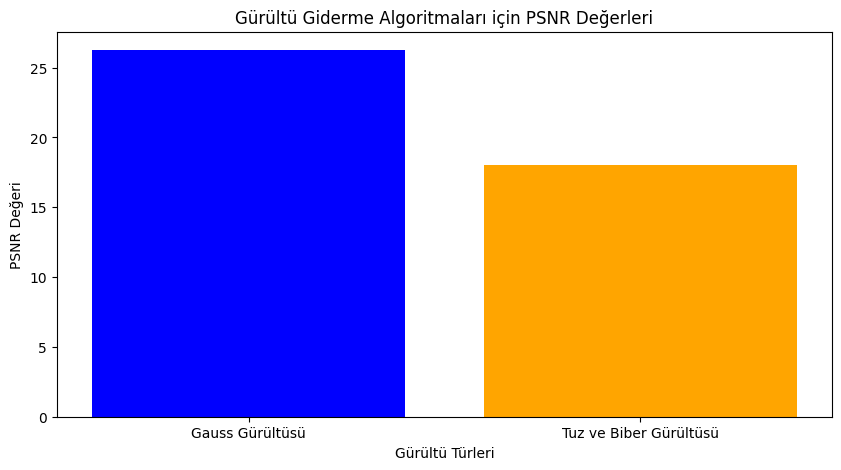

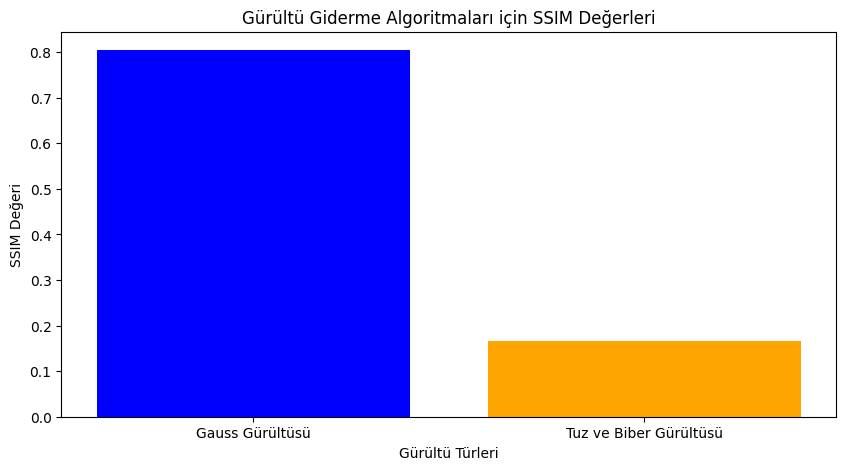

In [40]:
import matplotlib.pyplot as plt

# Performans ölçümleri için veriler
algorithms = ['Gauss Gürültüsü', 'Tuz ve Biber Gürültüsü']
psnr_values = [psnr_gauss, psnr_sp]
ssim_values = [ssim_gauss, ssim_sp]

# PSNR Değerlerinin Görselleştirilmesi
plt.figure(figsize=(10, 5))
plt.bar(algorithms, psnr_values, color=['blue', 'orange'])
plt.xlabel('Gürültü Türleri')
plt.ylabel('PSNR Değeri')
plt.title('Gürültü Giderme Algoritmaları için PSNR Değerleri')
plt.show()

# SSIM Değerlerinin Görselleştirilmesi
plt.figure(figsize=(10, 5))
plt.bar(algorithms, ssim_values, color=['blue', 'orange'])
plt.xlabel('Gürültü Türleri')
plt.ylabel('SSIM Değeri')
plt.title('Gürültü Giderme Algoritmaları için SSIM Değerleri')
plt.show()

## Sonuç
Bu raporda, Cooley-Tukey Hızlı Fourier Dönüşümü'nü (FFT) kullanarak görüntü gürültüsünü gidermeye yönelik bir algoritma geliştirilmiştir. Gauss ve tuz-biber gürültüleri ile kirletilmiş görüntüler üzerinde yapılan deneyler, önerilen yöntemlerin gürültüyü etkili bir şekilde giderebildiğini göstermektedir. PSNR ve SSIM gibi performans ölçümleri, filtrelenen görüntülerin orijinal görüntülere yakın olduğunu doğrulamaktadır. Bu çalışma, görüntü işleme alanında FFT'nin gücünü ve frekans alanı filtrelemenin etkinliğini vurgulamaktadır.